In [150]:
# pip install matplotlib

In [151]:
# pip install opencv-python

In [2]:
# pip install tensorflow

In [1]:
# pip install numpy==1.23

In [152]:
# Data Standardization

In [4]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

def preprocess_image(image, clip_limit=2.0, tile_grid_size=(8, 8)):
    """Apply CLAHE preprocessing with dynamic parameters."""
    height, width = image.shape[:2]

    if height >= 640 or width >= 640:
        upscale_image = cv2.resize(image, (1000, 1000), interpolation=cv2.INTER_LINEAR)
        processed_image = cv2.resize(upscale_image, (640, 640), interpolation=cv2.INTER_AREA)
    else:
        # Apply CLAHE with dynamic tileGridSize
        lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
        cl = clahe.apply(l)
        limg = cv2.merge((cl, a, b))
        clahe_image = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)
        processed_image = cv2.resize(clahe_image, (640, 640), interpolation=cv2.INTER_LINEAR)
    
    return processed_image

def show_and_save_processed_images(input_dir, output_dir="training_data/preprocessed_images", clip_limit=2.0, tile_grid_size=(8, 8)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in os.listdir(input_dir):
        file_path = os.path.join(input_dir, filename)
        if os.path.isfile(file_path):
            image = cv2.imread(file_path)
            if image is None:
                print(f"Error loading image: {file_path}")
                continue

            processed_image = preprocess_image(image, clip_limit, tile_grid_size)

            # Convert BGR to RGB for Matplotlib display
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            processed_image_rgb = cv2.cvtColor(processed_image, cv2.COLOR_BGR2RGB)

            # Ensure the processed image is saved correctly
            output_path = os.path.join(output_dir, f"processed_{filename}")
            success = cv2.imwrite(output_path, processed_image)
            if success:
                print(f"Saved processed image: {output_path}")
            else:
                print(f"Failed to save processed image: {output_path}")

            # Display images with labels
            fig, axes = plt.subplots(1, 2, figsize=(10, 5))

            for ax in axes:
                ax.set_anchor("C")  # Center image in each axis
                ax.set_xticks([])    # Remove X ticks
                ax.set_yticks([])    # Remove Y ticks
                ax.set_frame_on(False)  # Hide borders

            axes[0].imshow(image_rgb)
            axes[0].set_title("Original Image", fontsize=12, fontweight="bold", color="red")

            axes[1].imshow(processed_image_rgb)
            axes[1].set_title(f"Processed Image", fontsize=12, fontweight="bold", color="green")

            plt.subplots_adjust(wspace=0.5)  # Reduce space between images
            plt.show()


Saved processed image: training_data/preprocessed_images\processed_-20-_jpg.rf.0ac416a6c65f4cfd0ca5dc50fe7af312.jpg


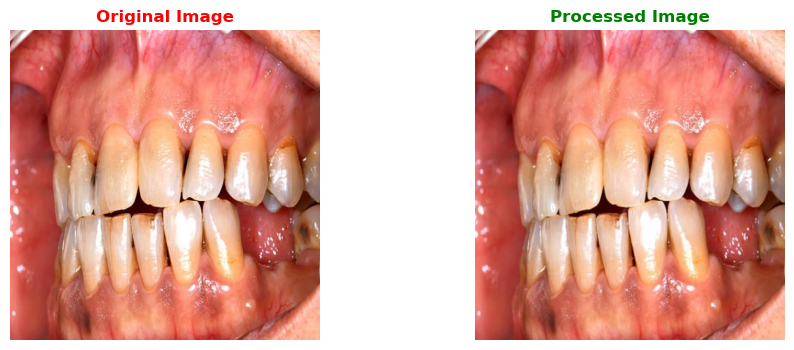

Saved processed image: training_data/preprocessed_images\processed_-35-_jpg.rf.9972f8335cac579cd7f187110c851c18.jpg


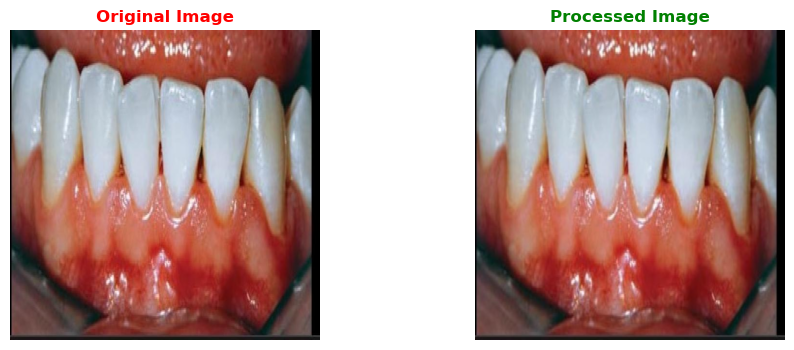

Saved processed image: training_data/preprocessed_images\processed_-41-_jpg.rf.768aaaa53470e100f15563bc14214d38.jpg


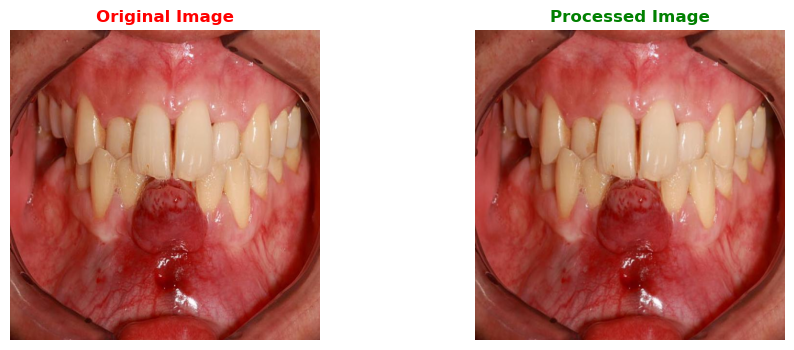

Saved processed image: training_data/preprocessed_images\processed_-47-_jpg.rf.c9b3f4eb33611aa93fb186cb874f4f69.jpg


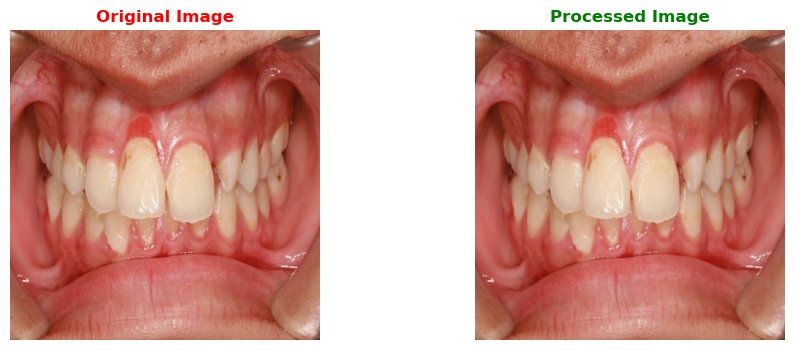

In [5]:
show_and_save_processed_images("training_data/raw_images", output_dir="training_data/preprocessed_images", clip_limit=0.8, tile_grid_size=(14, 14))

In [158]:
# Data Augmentation

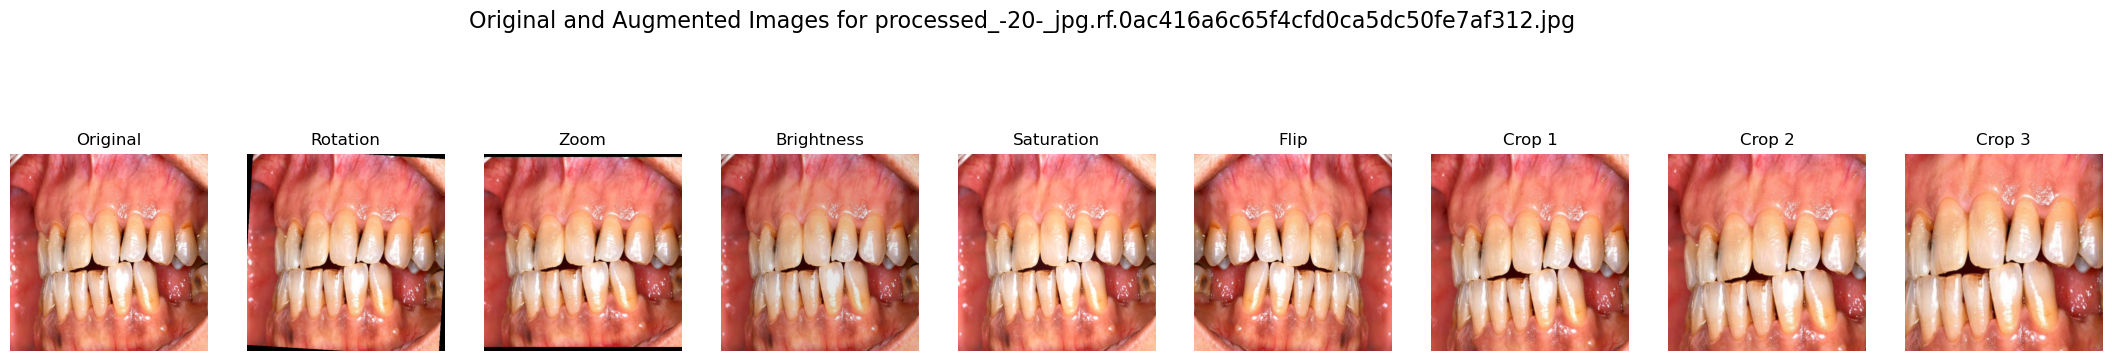

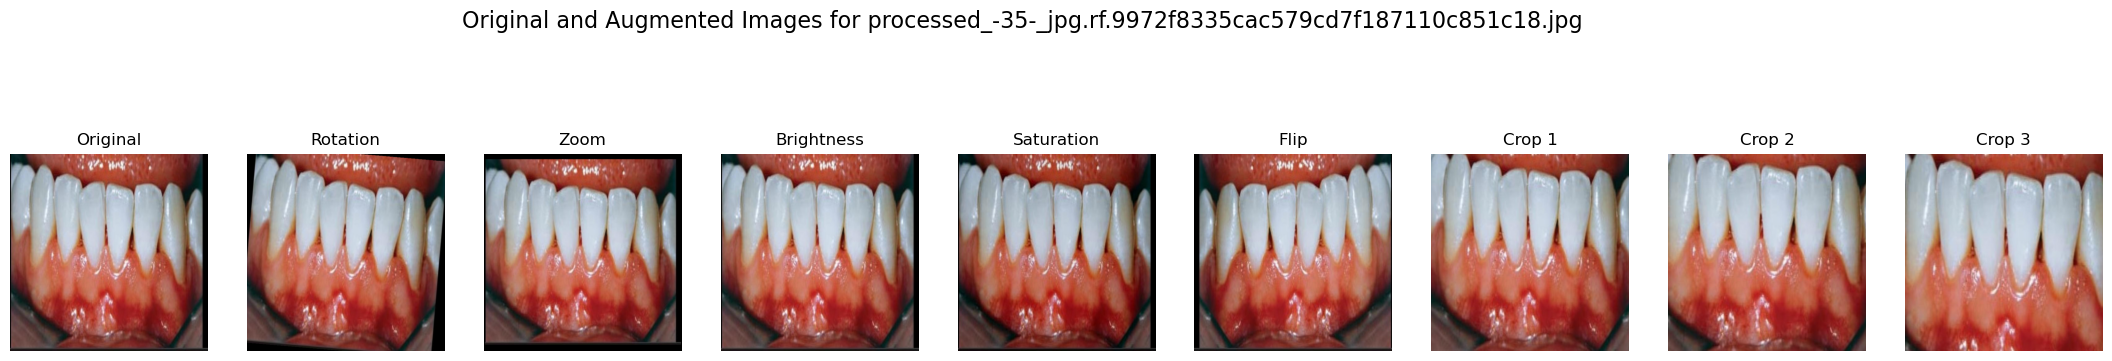

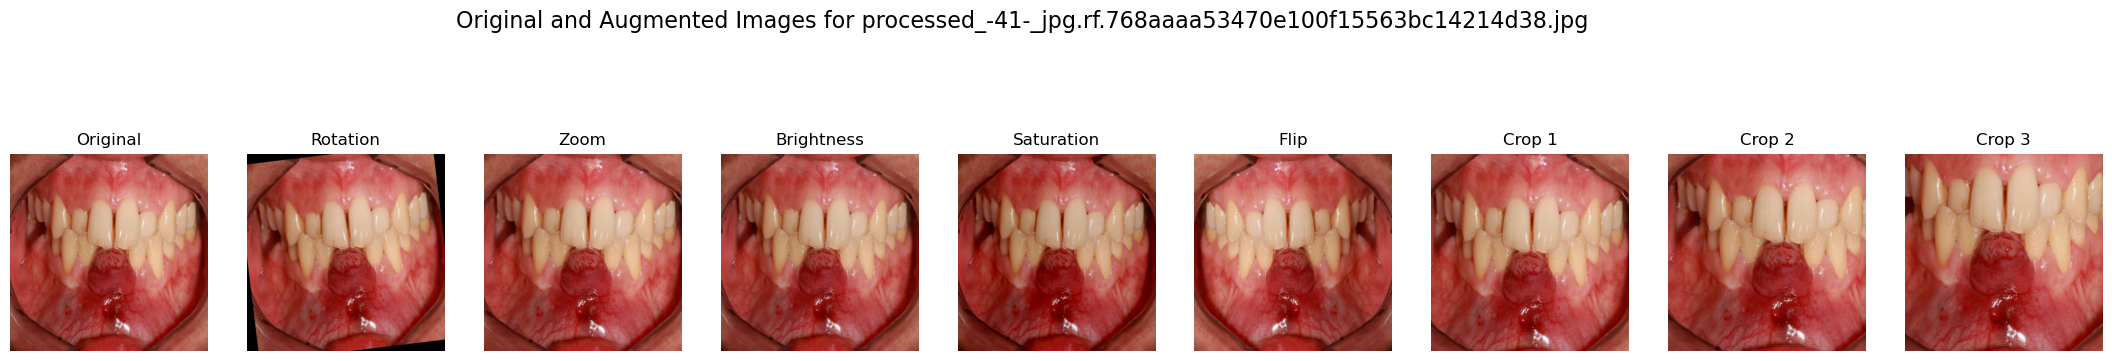

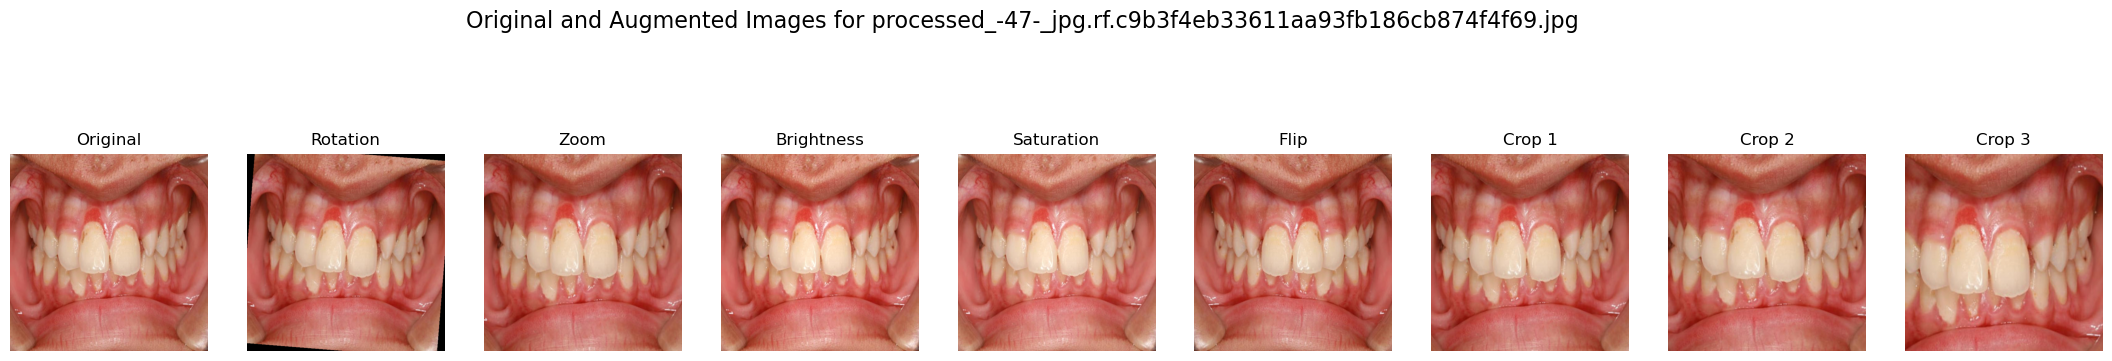

Data augmentation completed. Augmented images are displayed.


In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
import matplotlib.pyplot as plt

# Define input and output directories
input_dir = "training_data/preprocessed_images"
output_dir = "training_data/augmented_images"
os.makedirs(output_dir, exist_ok=True)

def random_crop(img_array, crop_size=(150, 150)):
    """Randomly crops an image to a given size while preserving details."""
    img_shape = img_array.shape
    height, width = img_shape[0], img_shape[1]

    crop_height, crop_width = crop_size  # Directly use the given crop size

    # Ensure crop size is smaller than the image size
    if crop_height > height or crop_width > width:
        raise ValueError("Crop size should be smaller than the original image size.")

    # Center-biased cropping (slightly random but mostly centered)
    x = np.random.randint(int(0.2 * (width - crop_width)), int(0.8 * (width - crop_width)) + 1)
    y = np.random.randint(int(0.2 * (height - crop_height)), int(0.8 * (height - crop_height)) + 1)

    # Perform the crop
    cropped_img = img_array[y:y+crop_height, x:x+crop_width]

    # Resize back to original dimensions
    cropped_img = tf.image.resize(cropped_img, (height, width))

    return cropped_img.numpy().astype('uint8')


def flip_image(img_array):
    """Manually flips the image horizontally"""
    return np.fliplr(img_array)

# Define separate augmentation generators
augmentation_configs = {
    "rotation": ImageDataGenerator(rotation_range=10, fill_mode='constant', cval=0),
    "zoom": ImageDataGenerator(zoom_range=[0.9, 1.1], fill_mode='constant', cval=0),
    "brightness": ImageDataGenerator(brightness_range=[0.9, 1.3]),
    "saturation": ImageDataGenerator(channel_shift_range=40-60)  # Added saturation augmentation
}

# Loop through each image in the input directory
for filename in os.listdir(input_dir):
    if filename.endswith(('.png', '.jpg', '.jpeg')):  # Check for valid image files
        img_path = os.path.join(input_dir, filename)
        img = load_img(img_path)  # Load the image
        img_array = img_to_array(img)  # Convert to array
        img_array = img_array.reshape((1,) + img_array.shape)  # Reshape for the generator
        
        base_name, ext = os.path.splitext(filename)
        
        # Define the total number of subplots: 1 original + 5 augmentations + 1 flip + 3 crops = 10
        fig, axes = plt.subplots(1, 9, figsize=(27, 5))  # Adjusted for saturation augmentation
        fig.suptitle(f"Original and Augmented Images for {filename}", fontsize=16)

        # Display the original image
        axes[0].imshow(img)
        axes[0].set_title("Original")
        axes[0].axis('off')
        
        img.save(os.path.join(output_dir, f"{base_name}_original{ext}"))  # Save original image

        # Display the augmented images (Rotation, Zoom, Brightness, Saturation)
        for i, (aug_name, datagen) in enumerate(augmentation_configs.items()):
            batch = next(datagen.flow(img_array, batch_size=1))  # Generate one augmented image
            augmented_img = batch[0].astype('uint8')

            axes[i + 1].imshow(augmented_img)
            axes[i + 1].set_title(aug_name.capitalize())
            axes[i + 1].axis('off')
            
            # Save the augmented image
            array_to_img(augmented_img).save(os.path.join(output_dir, f"{base_name}_{aug_name}{ext}"))

        # Display the flipped image
        flipped_img = flip_image(img_array[0].astype('uint8'))
        axes[5].imshow(flipped_img)
        axes[5].set_title("Flip")
        axes[5].axis('off')
        
        array_to_img(flipped_img).save(os.path.join(output_dir, f"{base_name}_flip{ext}"))

        # Apply random cropping with different sizes
        crop_sizes = [
            (int(img_array.shape[1] * 0.9), int(img_array.shape[2] * 0.90)),  # 90% crop
            (int(img_array.shape[1] * 0.85), int(img_array.shape[2] * 0.80)),  # 85% crop
            (int(img_array.shape[1] * 0.75), int(img_array.shape[2] * 0.75))  # 80% crop
        ]

        cropped_images = [random_crop(img_array[0].astype('uint8'), crop_size) for crop_size in crop_sizes]

        # Display the three different cropped images
        for i, cropped_img in enumerate(cropped_images):
            axes[6 + i].imshow(cropped_img)  # Now correctly mapped
            axes[6 + i].set_title(f"Crop {i+1}")
            axes[6 + i].axis('off')
            
            array_to_img(cropped_img).save(os.path.join(output_dir, f"{base_name}_crop{i+1}{ext}"))

        plt.show()  # Show the original and augmented images

print("Data augmentation completed. Augmented images are displayed.")